## Project Data representation, reduction and analysis
Satyam Kapoor <br>
Jeroen Van Soest

### Index



<a href='#section1'>1 Preprocessing</a>

<a href='#section2'>2 Feature extraction with TF-idf</a>

<a href='#section3'>3 Noise removal kMeans</a>

&nbsp;&nbsp;<a href='#section3_1'>3.1 Noise removal kMeans</a>

&nbsp;&nbsp;<a href='#section3_2'>3.2 Noise removal kMeans</a>

&nbsp;&nbsp;<a href='#section3_3'>3.3 Noise removal kMeans</a>




<a href='#section4'>4 Noise removal DBSCAN</a>

&nbsp;&nbsp;<a href='#section4_1'>4.1 creating the matrix to filter out noise points</a>

&nbsp;&nbsp;<a href='#section4_2'>4.2. Filter the DBSCAN noisy tweets out and produce the two datasets</a>

<a href='#section5'>5 Running K means on the two filtered datasets</a>

<a href='#section6'>6 Final results</a>

<a href='#section7'>7 Top ten of each cluster</a>

In [6]:
import nltk
import numpy as np
import collections
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn

from sklearn.metrics import silhouette_score
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import SnowballStemmer
from csv_helper import CSVHelper
from sklearn.cluster import DBSCAN


#required to filter noise and stem
nltk.download('stopwords')
nltk.download('wordnet')

data = CSVHelper.load_csv("Tweets_2016London.csv")

[nltk_data] Downloading package stopwords to /home/jeroen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jeroen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
starting for loop!


<a id='section1'></a>
## 1. Pre processing


In [7]:
def tokenize(tweets):
    tknzr = TweetTokenizer()
    tokenized_tweets = []
    for tweet in tweets:
        tokenized_tweets.append(tknzr.tokenize(tweet))
    return tokenized_tweets

def remove_stopwords(tweets):
    stopwords =  nltk.corpus.stopwords.words('english')
    stopwords.extend(("im","dont","wont"))
    tweets_nostop = []
    for tweet in tweets:
        tweet_nostop = [w.lower() for w in tweet if w.lower() not in stopwords]
        tweets_nostop.append(tweet_nostop)
    return tweets_nostop

def filter_names(tweets):
    tweets_filtered = []
    regex = re.compile("@([A-Za-z0-9_]+)")
    for tweet in tweets:
        tweet_filtered = [w for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

def filter_noise(tweets):
    tweets_filtered = []
    regex = re.compile("[^a-zA-Z]")
    for tweet in tweets:
        tweet_filtered = [re.sub("[^a-zA-Z]",'',w) for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

def remove_url(tweets):
    tweets_filtered = []
    regex = re.compile("^https?:\/\/.*[\r\n]*")
    for tweet in tweets:
        tweet_filtered = [w for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

#we decided to use a lemmatizer instead of stemming 
def my_stem(tweets):
    lmt = WordNetLemmatizer()
    ps = PorterStemmer()
    tweets_stemmed = []
    for tweet in tweets:
        tweet_stemmed = [lmt.lemmatize(w) for w in tweet]
        tweets_stemmed.append(tweet_stemmed)
    return tweets_stemmed

In [8]:
all_tweets = tokenize(data)
all_tweets = remove_url(all_tweets)
all_tweets = filter_names(all_tweets)
all_tweets = filter_noise(all_tweets)
all_tweets = remove_stopwords(all_tweets)
all_tweets = my_stem(all_tweets)

<a id='section2'></a>
## 2. Feature extraction with TF-IDF

The function create_tfidf_features  (input = array of tokenized tweets output = tf-idf feature matrix) Creates a distinct vocabulary set, and a dictionary (key val pairs)for each word in the vocabulary, calculated the IDF value, and for each term in each tweet, calculates the tfidf score (which is just the term frequency * IDF value)


https://nlpforhackers.io/tf-idf/

https://www.youtube.com/watch?v=4vT4fzjkGCQ&t=1s

http://billchambers.me/tutorials/2014/12/21/tf-idf-explained-in-python.html

In [9]:
def termfreq(word, tweet):
    #print("tweet:", doc, "length of tweet:", len(doc))
    num_words = len(tweet)
    word_occurences = tweet.count(word)
    return word_occurences/num_words

def count_doc_with_term(word, tweets):
    counter = 0
    for tweet in tweets:
        if word in tweet:
            counter = counter + 1
    return counter

#idf = amount_of_tweets/amount_of_tweets_with_word
def idf(word, tweets):
    num_tweets = len(tweets)
    num_tweets_with_word = count_doc_with_term(word, tweets)
    return np.log10(num_tweets/num_tweets_with_word)

def create_vocabulary(tweets):
    vocabulary = set() #creates a new set named vocabulary (set doesn't have duplicates)
    for tweet in tweets: #iterates over all tweets
        words = [w for w in tweet] #makes a list of words in a tweet (which our loop currently is in)
        vocabulary.update(words)#update teh vocab set 
    return list(vocabulary)

def compute_word_idf(tweets, vocabulary):
    word_idf = collections.defaultdict(lambda: 0)    #when I call x[k] for a nonexistent key k (such as a statement like v=x[k]), the key-value pair (k,0) will be automatically added to the dictionary, as if the statement x[k]=0 is first executed.  
    for w in vocabulary: #looping across each word in library to calculate the word's idf
        word_idf[w] = idf(w, tweets) #taking the wordidf dictionaries' key as the word and putting value as the idf
    return word_idf
    
def tf_idf(word, tweet, tweets, word_idf):
    if tweet != []:
        return termfreq(word, tweet) * word_idf[word]
    else:
        return 0
    
def tweet_tfidf_features(tweets):
    vocabulary = create_vocabulary(tweets)
    word_idf = compute_word_idf(tweets, vocabulary)
    tweet_features = np.empty(len(tweets), dtype=object)
    for i, tweet in enumerate(tweets):
        a = np.zeros(len(vocabulary))
        for j, word in enumerate(vocabulary):
            a[j] = tf_idf(word, tweet, tweets,word_idf)
        tweet_features[i] = a
    return np.vstack(tweet_features)

What is happening inside tweet_tfidf_features?

1) vocabulary = create_vocabulary(tweets) Creates a vocabulary set (non duplicate values in all words)
2) word_idf = returns a dictionary where key is the word and value is the word's idk


In [10]:
feature_matrix = tweet_tfidf_features(all_tweets)
feature_matrix.shape

(2001, 4480)

<a id='section3'></a>
## 3. K-means noise removal

In [11]:
def euclidean_vectorized(A, B):    
    n, d = A.shape
    m, d1 = B.shape
    assert d == d1, 'Incompatible shape'
    A_squared = np.sum(np.square(A), axis=1, keepdims=True)
    B_squared = np.sum(np.square(B), axis=1, keepdims=True)
    AB = np.matmul(A, B.T)
    distances = np.sqrt(A_squared - 2 * AB + B_squared.T)
    return distances

# X: data matrix of size (n_samples,n_features)
# n_clusters: number of clusters
# output 1: labels of X with size (n_samples,)
# output 2: centroids of clusters
def kmeans(X,n_clusters):
    # initialize labels and prev_labels. prev_labels will be compared with labels to check if the stopping condition
    # have been reached.
    prev_labels = np.zeros(X.shape[0])
    labels = np.zeros(X.shape[0])
    
    # init random indices
    # YOUR CODE GOES HERE
    indices = np.random.choice(X.shape[0], n_clusters, replace=False)# np.random.permutation(X.shape[0])[:n_clusters]
    
    # assign centroids using the indices
    # YOUR CODE GOES HERE
    centroids = X[indices]
    
    # the interative algorithm goes here
    while (True):
        
        #we had some numerical differences here
        centroids = np.nan_to_num(centroids)
        # calculate the distances to the centroids
        distances = sk.metrics.pairwise.cosine_distances(X,centroids)
       
        # assign labels
        labels = np.argmin(distances,axis=1)
        # stopping condition
        if np.array_equal(labels, prev_labels):
        #if np.sum(labels != prev_labels) == 0:
            break
        
        # calculate new centroids
        for cluster_indx in range(centroids.shape[0]):
            members = X[labels == cluster_indx]
            centroids[cluster_indx,:] = np.mean(members,axis=0)
        centroids = np.nan_to_num(centroids)    
        #plt.plot(labels, 'ro')
        #plt.show()
        
        # keep the labels for next round's usage
        prev_labels = np.argmin(distances,axis=1)
    
    return labels,centroids
    

<a id='section3_1'></a>
### 3.1 Creating the consensus matrix with k-means

/home/jeroen/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jeroen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


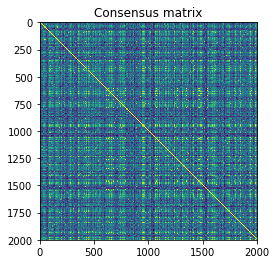

In [12]:
def consensus_matrix_kmeans(minclusters, maxclusters, features):
    consensus_matrix = np.zeros((features.shape[0],features.shape[0]))
    for i in np.arange(minclusters, maxclusters, 1):
        cluster_labels, centroids = kmeans(features, i)
        #sil_score = silhouette_score(features, cluster_labels)
        #print("silhouette score for k=",i, 'is:',sil_score)
        for i in range(len(cluster_labels)):
            for j in range(len(cluster_labels)):
                if cluster_labels[i] == cluster_labels[j]:
                    consensus_matrix[i,j] = (consensus_matrix[i,j] + 1)
                    #print(cluster_labels[i],cluster_labels[j],consensus_matrix[i,j])
                

    plt.imshow(consensus_matrix)
    plt.title('Consensus matrix')
    plt.legend()
    plt.show()
    return consensus_matrix
    
consensus_matrix = consensus_matrix_kmeans(2,15, feature_matrix)

<a id='section3_2'></a>
## 3.2. 10 percent treshold of the consensus matrix
In this step, if a pair (i, j) of tweets did not cluster together more than 10% of the total number of runs, the position (i, j) in the consensus matrix is set to 0.

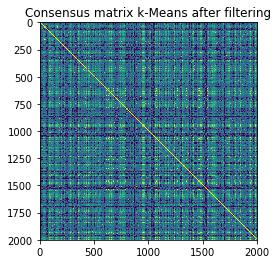

In [13]:
for i in range(len(consensus_matrix)):
    for j in range(len(consensus_matrix)):
        if consensus_matrix[i,j] <= 2:
            consensus_matrix[i,j] = 0

plt.imshow(consensus_matrix)
plt.title('Consensus matrix k-Means after filtering')
plt.legend()
plt.show()

<a id='section3_3'></a>
## 3.3 filtering the noisy tweets out
To detect noise, we will look at the row sums for the consensus
matrix and employed a threshold
value. Tweets, whose row sum are less than that threshold val
ue are, marked as noise points. The
threshold value is determined by the average of all the entri
es in the constructed consensus matrix.

In [15]:
row_mean = consensus_matrix.mean(1)
matrix_mean = consensus_matrix.mean()

#create clean tweets that removes the noise points
kmeans_filtered_tweets = []
for i in range(len(all_tweets)):
    if row_mean[i] >= matrix_mean:
        kmeans_filtered_tweets.append(all_tweets[i])




<a id='section4'></a>
## 4. Noise removal with DBSCAN (SciKit)

In [16]:
consensus_DBSCAN = np.zeros((feature_matrix.shape[0],5))
minPts = 5
epsmin = 0.91
epsmax = 1.05

for i, epsilon in enumerate(np.arange(epsmin, epsmax, 0.03)):
    print(i,", eps = ",epsilon)
    db = DBSCAN(eps=epsilon,min_samples=minPts)
    db.fit(feature_matrix)
    labels = db.labels_
    core_pts = db.core_sample_indices_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('%d clusters found' %(n_clusters_))
    for k in range(0,feature_matrix.shape[0]):
        if k in core_pts:
            consensus_DBSCAN[k][i] = 1.0 #dense
        else:
            consensus_DBSCAN[k][i] = 0 #border or outlier
#print(labels)
#plt.plot(labels, 'ro')
#plt.show()
#print(db.core_sample_indices_)

0 , eps =  0.91
3 clusters found
1 , eps =  0.94
3 clusters found
2 , eps =  0.97
3 clusters found
3 , eps =  1.0
3 clusters found
4 , eps =  1.03
3 clusters found


<a id='section4_1'></a>
## 4.1. Creating the matrix to filter out noise points

In [17]:
consensus_DBSCAN_results = np.zeros((consensus_DBSCAN.shape[0],1))
for numb in range (0,consensus_DBSCAN.shape[0]):
    
    zeroes = 0 #border or outlier
    ones = 0
    for r in range(0,consensus_DBSCAN.shape[1]):
        if consensus_DBSCAN[numb][r] == 1:
            ones = ones+1
        else:
            zeroes = zeroes + 1
        

        
    threshold = (consensus_DBSCAN.shape[1]*50)/100
    if zeroes > threshold:
        consensus_DBSCAN_results[numb][0] = 0 #noise
    else:
        consensus_DBSCAN_results[numb][0] = 1 #not noise



#plt.plot(consensus_DBSCAN_results, 'ro')
#plt.show()

<a id='section4_2'></a>

## 4.2. Filter the DBSCAN noisy tweets out and produce the two datasets

In [26]:
dbscan_filtered_tweets = []
for i in range(0, consensus_DBSCAN.shape[0]):
    if consensus_DBSCAN_results[i][0] == 1:
        dbscan_filtered_tweets.append(all_tweets[i])

        
        
kmeans_filtered_tweets_idf = tweet_tfidf_features(kmeans_filtered_tweets)
dbscan_filtered_tweets_idf = tweet_tfidf_features(dbscan_filtered_tweets)


print(kmeans_filtered_tweets_idf.shape)
print(dbscan_filtered_tweets_idf.shape) #it stores the filtered tweet's tfidf

(1019, 2476)
(873, 2972)


<a id='section5'></a>

## 5. Running K means on the two filtered datasets

Here we construct the two consensus matrices for the datasets

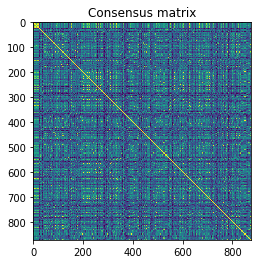

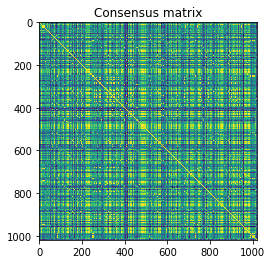

In [27]:
mink = 2
maxk = 12


consensus_kmeans = consensus_matrix_kmeans(mink, maxk, dbscan_filtered_tweets_idf)
consensus_dbscan = consensus_matrix_kmeans(mink, maxk, kmeans_filtered_tweets_idf)

<a id='section6'></a>
## 6. Final clustering result

In [23]:
labels_kmeans, centroids_kmeans = kmeans(consensus_kmeans, 9)
labels_dbscan, centroids_dbscan = kmeans(consensus_dbscan, 9)

/home/jeroen/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jeroen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<a id='section7'></a>
## 7. Top ten of each cluster

In [45]:
def topten(tweetlist, centroids):
    true_k = 9

    print("Top terms per cluster:")
    order_centroids = centroids_dbscan.argsort()[:, ::-1]
    terms = create_vocabulary(dbscan_filtered_tweets)
    for i in range(true_k):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[int(ind)])
        print

topten(dbscan_filtered_tweets, centroids_dbscan)
topten(kmeans_filtered_tweets, centroids_kmeans)

#https://stackoverflow.com/questions/27889873/clustering-text-documents-using-scikit-learn-kmeans-in-python


Top terms per cluster:
Cluster 0:
 half
 down
 gmt
 beer
 legally
 wine
 acted
 smoothie
 bait
 johnny
Cluster 1:
 detained
 westminster
 time
 sea
 nationwide
 spring
 clapping
 wildly
 grownup
 branagh
Cluster 2:
 detained
 westminster
 time
 sea
 nationwide
 spring
 clapping
 wildly
 grownup
 branagh
Cluster 3:
 france
 benefit
 wtf
 step
 wouldnt
 reflect
 st
 venue
 method
 else
Cluster 4:
 attending
 end
 tackle
 pub
 saturday
 hashtag
 referendum
 answer
 jury
 guardian
Cluster 5:
 pint
 cctv
 gift
 repeating
 listen
 bcg
 anytime
 managing
 kill
 tbh
Cluster 6:
 tnitefor
 announce
 neighbourhood
 ignored
 yr
 think
 broken
 uefa
 custody
 politically
Cluster 7:
 detained
 westminster
 time
 sea
 nationwide
 spring
 clapping
 wildly
 grownup
 branagh
Cluster 8:
 turn
 liked
 goodwill
 seems
 music
 busted
 shouldve
 seat
 usa
 bastille
Top terms per cluster:
Cluster 0:
 half
 down
 gmt
 beer
 legally
 wine
 acted
 smoothie
 bait
 johnny
Cluster 1:
 detained
 westminster
 time
 s